In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
import os

In [4]:
import sys

In [5]:
import itertools

In [6]:
import copy

In [7]:
import HTSeq
import pysam

In [8]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [9]:
%load_ext autoreload
%autoreload 2

------------------------------

## Config

In [10]:
project_data_dir = '/gcm-lfs1/pablo/data/rna_silencing'

In [11]:
project_dir = '/home/pmonteagudo/workspace/silencing_project'

In [12]:
scripts_dir = os.path.join(project_dir, 'htseq/scripts')
if scripts_dir not in sys.path: 
    sys.path.append(scripts_dir)
import coverage as cov

- other **directories**

In [13]:
data_dir = os.path.join(project_data_dir, 'seq_data')

In [14]:
results_dir = os.path.join(project_data_dir, 'results')

------

# Test Coverage Plots

--------------------------

## Heterochomatic Genes

In [15]:
# ------------------------------
# A. Centromeric repeats `deg1`: dg, dh counts
# ------------------------------

#deg1 = ['dh1', 'dg1'] ## unstranded
#deg1 = ['dh1+',  'dh1-', 'dg1+', 'dg1-']
deg1 = ['dg1a', 'dg1b', 'dh1a', 'dh1b'] ## gff_v2
deg1_names = {'dg1a': 'dg1+', 'dg1b': 'dg1-',
              'dh1a': 'dh1+', 'dh1b': 'dh1-'}

# -----------------------------
# B. Subtelomeric Genes `deg2`: tlh, SPAC212.10 counts
# -----------------------------

#deg2 = ['tlh1', 'SPAC212.10'] ## unstranded
#deg2 = ['tlh1+', 'tlh1-', 'SPAC212.10']
deg2 = ['SPAC212.11', 'SPAC212.11b', 'SPAC212.10', 'SPAC212.10b'] ## gff_v2
deg2_names = {'SPAC212.11': 'tlh1-', 'SPAC212.11b': 'tlh1+',
              'SPAC212.10': 'SPAC212.10-', 'SPAC212.10b': 'SPAC212.10+'}

# ------------------------------------
# C.  Mating type region (MTR) `deg3`: MAT, other regions, etc... counts 
# ------------------------------------

deg3 = ['MAT2', 'MAT3', 'MAT1']
deg3_names = {'MAT1': 'MAT1', 'MAT2': 'MAT2', 'MAT3': 'MAT3'}

# ------------------------------------------
# D. rest Heterochromatic + mat gene counts: `deg4`
# ------------------------------------------

non_degraded = ['SPAC212.09c', 'SPNCRNA.70', 'SPAC212.08c', 'SPAC212.07c', 'SPAC212.12', 'SPAC212.06c',
                'SPAC212.04c', 'SPAC212.03', 'SPAC212.02', 'SPAC212.01c', 'SPAC977.01', 'SPAC977.18',
                'SPAC977.02', 'SPAC977.03', 'SPAC977.04', 'SPAC212.05c']
                #'MAT2', 'MAT3', 'MAT1']
    
# ---------------
# E. Other genes: `other_genes`
# ---------------

other_genes = ['SPAC212.09c', 'SPAC977.01', 'SPAC977.10', 'SPAP7G5.06']
other_gene_nanes = {'SPAC212.09c':'SPAC212.09c', 'SPAC977.01':'ftm1', 'SPAC977.10':'nhe1', 
                    'SPAP7G5.06':'per1'}

htc_genes = deg1 + deg2
visualize_genes = deg1 + deg2 + deg3 + other_genes
visualize_gene_names = {**deg1_names, **deg2_names, **deg3_names, **other_gene_nanes}

--------------------------

## Define Parameters

- Define `sample`

In [16]:
#data_batch = "S2-ChIP"
#data_batch = "S5-RIP"
data_batch = "pA-RNA"
#data_batch = "simulated_data"

In [17]:
#sample_id = 'WT_S2-ChIP_1'
#sample_id = 'WT_S5-RIP_1'
sample_id = 'WT_pA-RNA_1'
sample_id = 'WT_pA-RNA_4'
#sample_id = 'fake_reads'
#sample_id = 'fake_reads_v2'

- **Output directory** for `sample` coverage results

In [18]:
out_dir = os.path.join(results_dir, data_batch, "coverage", sample_id)

- Load **BAM files**: instantiate `BAM_Reader` Object

In [19]:
bam_file = os.path.join(data_dir, data_batch, "bam", sample_id, sample_id + ".Aligned.sortedByCoord.out.bam")
#print(bam_file)
#bam = HTSeq.BAM_Reader(bam_file)

- Select **gtf file**: instantiate `GFF_Reader` Object

In [20]:
param_in_gtf = os.path.join(project_data_dir, 'annotation/gff_v2/Schizosaccharomyces_pombe_all_chromosomes.extended_with_mat_locus.gff3')

In [21]:
# select gtf file: instantiate GFF_Reader Object
gtf = HTSeq.GFF_Reader(param_in_gtf)

- **Fragment size** smoothes coverage profile:

In [22]:
#fragment_size = 500
#fragment_size = 200
fragment_size = None

--------------------------

## Genomic Features

- Define characteristics for **coverage interval**: 
    * Centromeric repeats dg, dh
    * Subtelomeric & telomeric genes tlh, SPAC212.10, etc...
    * Mating type region (MTR) MAT, other regions, etc...

In [23]:
## instead we can follow:
## https://htseq.readthedocs.io/en/master/tss.html#using-indexed-bam-files
i_1 = {'region_id':'Subtelomeric_and_Telomeric_region', 'chrom':'I', 'start': 1, 'end': 55000}
i_2 = {'region_id':'Centromeric_repeats', 'chrom':'I', 'start': 3748000, 'end': 3766000}
i_3 = {'region_id':'Mating_type_region', 'chrom':'II', 'start': 2113000, 'end': 2138000}
#i_3 = {'region_id':'Mating_type_region_chromosome', 'chrom':'mating_type_region', 'start': 1, 'end': 20,128} ## whole chromosome
genomic_intervals = [i_1, i_2]
#genomic_intervals = [i_1, i_2, i_3]

- Get **genomic features** in regions of interest:

In [24]:
feature_types = ['gene']

In [25]:
init_feature_dict = {'region_id':[], 'feature_id':[], 'feature_name':[], 'type':[], 'chrom':[], 'start':[], 'end':[], 'strand':[]}

In [26]:
genomic_features = {gg['region_id']: copy.deepcopy(init_feature_dict) for gg in genomic_intervals}
#genomic_features

In [27]:
## Loop over features in gtf
for feature in gtf:
    
    if feature.type in feature_types:
            
        ## Loop over genomic regions of interest: check if `feature` falls within the genomic region
        for gi in genomic_intervals:
            
            if (feature.iv.chrom == gi['chrom'] and feature.iv.start + 1 >= gi['start'] and feature.iv.end + 1 <=  gi['end']):
                
                genomic_features[gi['region_id']]['region_id'].append(gi['region_id'])
                genomic_features[gi['region_id']]['feature_id'].append(feature.attr["ID"])
                try:
                    genomic_features[gi['region_id']]['feature_name'].append(feature.attr["Name"])
                except:
                    genomic_features[gi['region_id']]['feature_name'].append(np.nan)
                genomic_features[gi['region_id']]['type'].append(feature.type)
                genomic_features[gi['region_id']]['chrom'].append(feature.iv.chrom)
                genomic_features[gi['region_id']]['start'].append(feature.iv.start)
                genomic_features[gi['region_id']]['end'].append(feature.iv.end)
                genomic_features[gi['region_id']]['strand'].append(feature.iv.strand)

In [28]:
#genomic_features['Subtelomeric_and_Telomeric_region']

- Transform to **Data Frames**

In [29]:
genomic_features_dfs = {}

In [30]:
for region_id, gg_features in genomic_features.items():
    genomic_features_dfs[region_id] = pd.DataFrame.from_dict(gg_features)

In [31]:
genomic_features_df = genomic_features_dfs['Subtelomeric_and_Telomeric_region']
#genomic_features_df = genomic_features_dfs['Centromeric_repeats']
#genomic_features_df = genomic_features_dfs['Mating_type_region']

- **Visualize** `genomic features` in `genomic region`

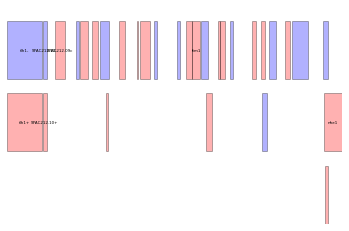

In [32]:
annotate_features = True
annotate_features = visualize_gene_names

# Create figure and axes
fig, ax = plt.subplots(nrows = 1, ncols=1)

cov.plot_non_overlapping_features(genomic_features_df, ax = ax, annotate_features = annotate_features)

plt.savefig('test.pdf')
plt.show()

--------------------------

## Coverage Vectors: with Genomic Features

- Instantiate a `GenomicArray` object for the **sample** coverage (`cvg`)

In [33]:
#cvg = cov.coverage_genomic_intervals(bam_file, genomic_intervals, count_type="frac", fragment_size=fragment_size)
cvg = cov.coverage_genomic_intervals(bam_file, genomic_intervals, count_type="int", stranded=True, fragment_size=fragment_size)

Loading BAM file ...
/gcm-lfs1/pablo/data/rna_silencing/seq_data/pA-RNA/bam/WT_pA-RNA_3/WT_pA-RNA_3.Aligned.sortedByCoord.out.bam
Done.

Adding padding: 0 

Genomic Regions:
	- I:1-55000 (55.00 kb)
	- I:3748000-3766000 (18.00 kb)


In [34]:
#cvg

- Alternatively, **Import** `GenomicArray` object for the **sample** coverage (`cvg`)

In [35]:
int_cvg_file = os.path.join(out_dir, "int_cvg_" + sample_id + "_coverage.obj")
fract_cvg_file = os.path.join(out_dir, "frac_cvg_" + sample_id + "_coverage.obj")

In [36]:
#import pickle

# Import Objects:
#cvg = pickle.load(open(int_cvg_file, 'rb'))
#cvg = pickle.load(open(fract_cvg_file, 'rb'))

- **Visualize coverage** (`cvg`) in the genomic intervals of interest

In [37]:
cvg_profiles = {}
feature_annotations = {}

In [38]:
## - Get Data Frames **genomic features** in regions of interest:
#genomic_features_dfs = get_genomic_features_dfs(genomic_intervals, param_in_gtf, feature_types=['gene'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7eff10058eb8>,
      dtype=object)

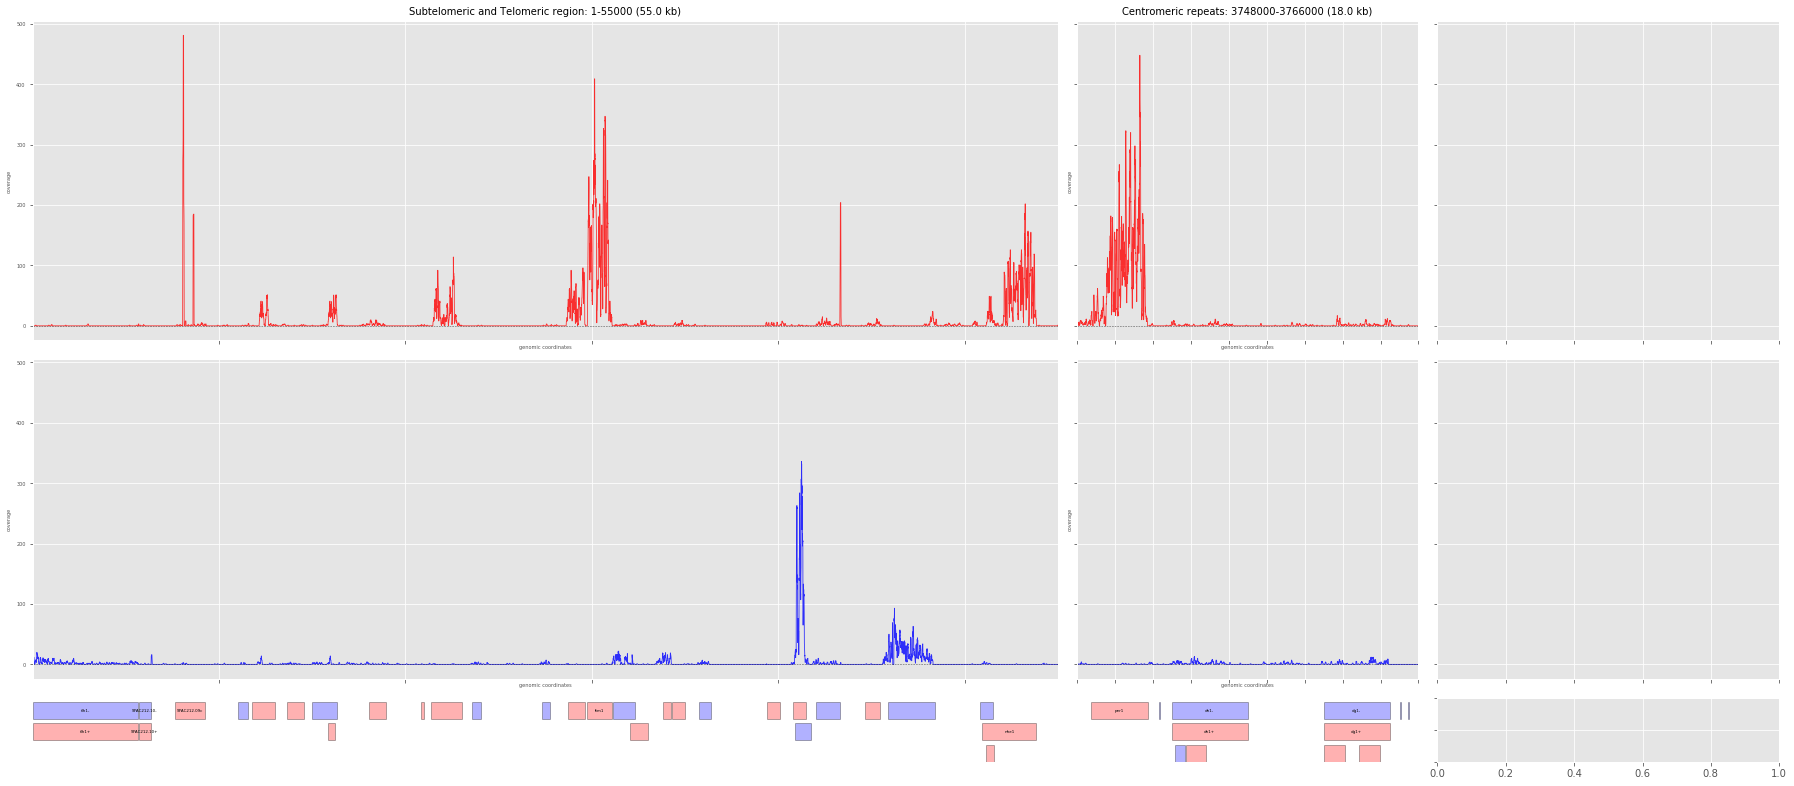

In [39]:
annotate_features = True
annotate_features = visualize_gene_names
#y_scale = "log"
y_scale = "linear"
cov.plot_coverage_genomic_regions(genomic_intervals, cvg, genomic_features_dfs, stranded=True, annotate_features=visualize_gene_names, y_scale=y_scale, prefix='frac_')

In [40]:
#cvg_profiles